In [125]:
library(tidyverse)
library(gghighlight)
library(magrittr)
library(scales)


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [178]:
source("../R/alg/cma-es-csa.R")
source("../R/alg/cma-es-expth.R")
source("../R/alg/cma-es-tpat.R")
source("../R/eval-funcs.R")
source("../R/plot-funcs.R")
options(repr.plot.width=30, repr.plot.height=30)

In [9]:
eval = noise_func
x0 = rep(10, 10)

In [11]:
csa = 
    cma_es_csa(x0, fn = eval, lower = -100, upper = 100)
tpat = 
    cma_es_tpat(x0, fn = eval, lower = -100, upper = 100)

In [201]:
ppmf_factory = function(dparams, ptargets) {
    expand.grid(
        dp = dparams,
        pt = ptargets
    ) %>%
    purrr::pmap(function(dp, pt){
        control = list(d_param = dp, p_target = pt)
        purrr::partial(cma_es_ppmf, control = control)
    })
}
sigma_plot = function(dfx){ 
    dfx %>% ggplot2::ggplot(aes(x = t, y = sigma, col = label2)) +
    ggplot2::geom_line() +
    ggplot2::scale_y_log10(breaks = trans_breaks("log10", function(x) 10^x),
              labels = trans_format("log10", math_format(10^.x))) +
     gghighlight::gghighlight(is.character(label2), use_direct_label = TRUE, label_params = list(size = 6)) +
    theme_bw() + facet_wrap( ~ pt) + 
    ggplot2::theme(
        axis.title = ggplot2::element_text(size = 15, face = "bold"),
        axis.text = ggplot2::element_text(size = 15, face = "bold"),
        legend.text = ggplot2::element_text(size = 15, face = "bold"),
        strip.text = ggplot2::element_text(size = 15, face = "bold"),
        legend.title = ggplot2::element_text(size = 15, face = "bold")
    )
}

In [98]:
sigma_exp = function(fns, Ns) {
    expand.grid(
        f = fns,
        N = Ns
    ) %>%
    purrr::pmap(function(f, N) {
        tryCatch({
            result = f(rep(0, N), fn = eval, lower = -100, upper = 100)
              t = length(result$diagnostic$sigma)
            tibble::tibble(
                t = 1:t,
                N = N,
                sigma = result$diagnostic$sigma,
                label = result$label,
            )
        }, error = function(error) {
            return(NA)
        })
    })
}

In [138]:
d_param = c(0.1, 0.5, 0.6, 0.8, .9,  1, 2, 2.5, 3, 4, 5, 10, 50, 100)
p_target = c(0.1, 0.2, 0.3, 0.4, 0.5, 0.6)

In [139]:
ppmfs = ppmf_factory(d_param, p_target)

In [140]:
results = ppmfs %>% sigma_exp(Ns = c(10))

In [141]:
sigma_df = results[!is.na(results)] %>% purrr::reduce(dplyr::bind_rows)

In [166]:
sigma_df %<>% dplyr::mutate(
    dp = stringr::str_extract(label, "dp-(\\d.*)(?=-pt)"),
    pt = stringr::str_extract(label, "pt-(\\d.*)"),
    label2 = stringr::str_extract(label, "dp-(\\d.*)")
)

label_key: label2

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


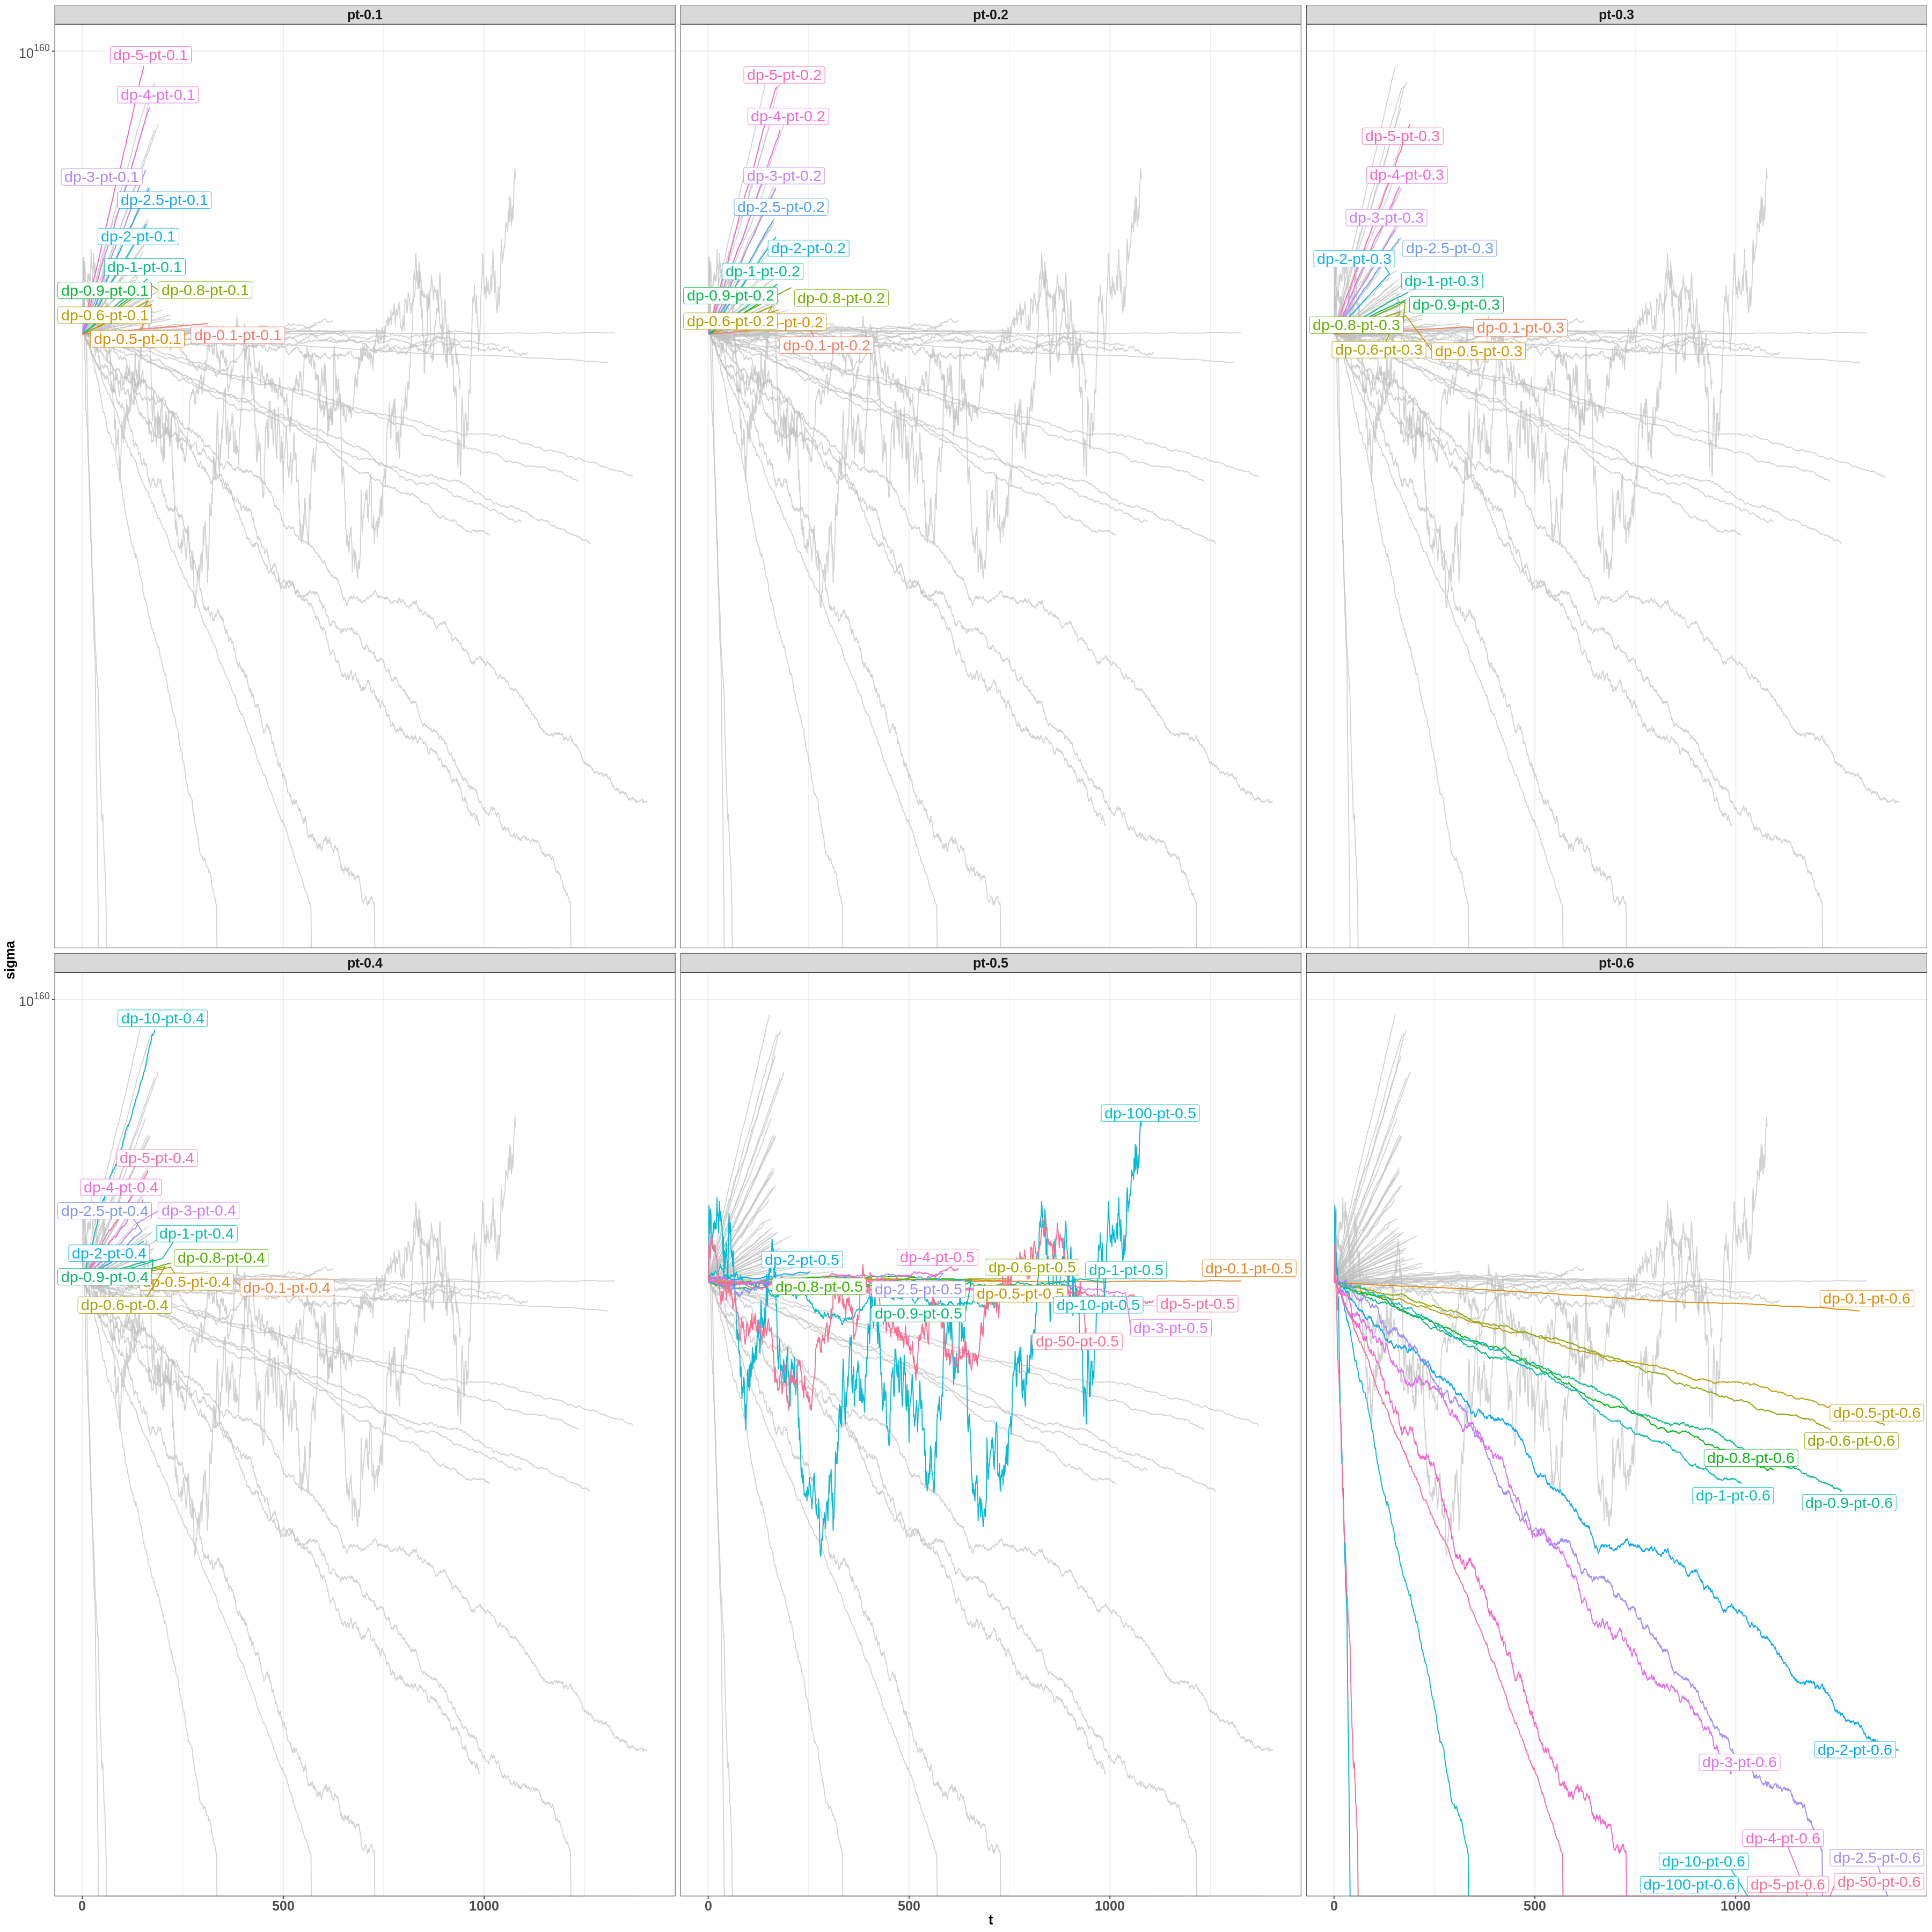

In [202]:
sigma_df %>% sigma_plot()